In [1]:
import os
import sys
import subprocess
from pathlib import Path


def get_project_root():
    # get the absolute path to the root of the git repo
    root = subprocess.check_output(["git", "rev-parse", "--show-toplevel"]).strip().decode("utf-8")
    return Path(root)

# get project root and append it to path
project_root = get_project_root()
sys.path.append(str(project_root))

# embeddings path
dataset = "waymo"
data_dir = f"{dataset}_data"
base_path = os.path.normpath(os.path.join(project_root, ".."))

# output dir
out_reldir = f"out/control-vectors/{dataset}/"
out_path = os.path.join(base_path, out_reldir)

In [ ]:
import os
from glob import glob
from utils.embs_all import load_embeddings
from utils.embs_contrastive import load_contrastive_embed_pairs


# load data
data_path = os.path.join(base_path, "data", data_dir)
paths_inputs = sorted(glob(f"{data_path}/input*"))
paths_embeds = sorted(glob(f"{data_path}/target_embs*"))

# stack embeddings wrt types
embs = load_embeddings(paths_inputs, paths_embeds)

# trim and stack contrastive pairs of embeddings
contrastive_embs = load_contrastive_embed_pairs(embs)

100%|██████████| 204/204 [00:00<00:00, 601.07it/s]


In [3]:
import torch
from utils.embs_all import EmbeddingData


# slice data for nc metrics
stack = lambda data: torch.stack([torch.mean(entry, dim=0) for entry in data])
stack = lambda data: data

control_features = {}

control_features["high"] = EmbeddingData()
control_features["high"].data = stack(contrastive_embs["speed"][:len(contrastive_embs["speed"]) // 2])

control_features["low"] = EmbeddingData()
control_features["low"].data = stack(contrastive_embs["speed"][len(contrastive_embs["speed"]) // 2:])

control_features["accelerate"] = EmbeddingData()
control_features["accelerate"].data = stack(contrastive_embs["acceleration"][:len(contrastive_embs["acceleration"]) // 2])

control_features["decelerate"] = EmbeddingData()
control_features["decelerate"].data  = stack(contrastive_embs["acceleration"][len(contrastive_embs["acceleration"]) // 2:])

control_features["right"] = EmbeddingData()
control_features["right"].data = stack(contrastive_embs["direction"][:len(contrastive_embs["direction"]) // 2])

control_features["left"] = EmbeddingData()
control_features["left"].data = stack(contrastive_embs["direction"][len(contrastive_embs["direction"]) // 2:])

control_features["vehicle"] = EmbeddingData()
control_features["vehicle"].data = stack(contrastive_embs["agent"][:len(contrastive_embs["agent"]) // 2])

control_features["pedestrian"] = EmbeddingData()
control_features["pedestrian"].data = stack(contrastive_embs["agent"][len(contrastive_embs["agent"]) // 2:])


In [4]:
print(control_features["high"].data.shape)
control_features["high"].mean

torch.Size([1222, 11, 128])


tensor([ 1.3685e-01,  4.4773e-01,  1.4762e+00, -1.0055e+00,  8.0444e-01,
         3.0140e+00,  4.8010e+00, -1.7174e-01, -3.3573e+00,  5.5094e-01,
         2.3153e+00, -3.3498e-01,  1.1264e+00,  8.7314e-01,  4.4325e+00,
         2.5025e+00, -3.6080e-01,  1.1920e+00, -7.2500e-01, -1.9866e+00,
        -7.1107e-01,  4.1702e-01, -3.8166e+00,  3.2620e-01, -1.4430e+00,
         6.8312e-01, -1.2789e+00,  9.5377e-01, -4.6678e+00, -2.0280e+00,
         2.0151e+00, -2.7104e+00,  4.2273e+00,  1.0299e+00, -2.9712e+00,
         2.3508e+00,  1.8688e+00,  4.5718e+00,  4.0930e-01, -4.8555e-01,
         4.7106e-01,  1.5033e+00,  9.0008e-01,  6.3758e-01,  1.7404e+00,
         2.2200e+00, -2.4905e+00,  1.6653e+00,  1.9364e+00,  4.0971e-01,
         2.0652e+00,  1.6367e+00, -2.5707e-01, -3.0014e+00, -8.8809e-01,
        -7.4250e-01,  8.4854e-01,  1.6423e+00,  3.7921e+00,  1.3377e+00,
        -1.5043e+00,  9.5969e-01, -6.3998e-02, -4.5364e+00,  2.5233e-01,
         4.0406e+00,  3.7554e-01, -2.1753e+00,  3.3

In [5]:
import torch
from tqdm import tqdm


# calculate true global mean
idx_layer = 2
tmp = []
# loop over data files
for (path_input, path_embs) in tqdm(zip(paths_inputs, paths_embeds)):
    e = torch.load(path_embs, map_location=torch.device('cpu'))
    # loop over batches (48 default)
    for idx_batch in range(len(e)):
        # loop over timesteps (11 default)
        for idx_ts in range(len(e[idx_layer][idx_batch])):
            tmp.append(e[idx_layer][idx_batch][idx_ts])



204it [00:00, 2019.54it/s]


In [6]:
len(tmp)

6732

In [7]:
tmp[0].shape

torch.Size([128])

In [8]:
tmp = torch.stack(tmp)
control_features["global"] = EmbeddingData()
control_features["global"].data = tmp
control_features["global"].mean = torch.mean(tmp, dim=0)
control_features["global"].var = torch.var(tmp, dim=0, unbiased=False)
tmp.shape

torch.Size([6732, 128])

In [9]:
import itertools
import torch
import numpy as np
from pprint import pprint


def pairwise_l2_distances(class_means):

    C = len(class_means)
    class_indices = list(range(C))
    class_pairs = list(itertools.combinations(class_indices, 2))

    out = []
    for (c1, c2) in class_pairs:
        mean_c1 = class_means[c1]
        mean_c2 = class_means[c2]
        distance = torch.norm(mean_c1 - mean_c2, p=2)
        out.append(distance)

    return torch.stack(out)


def fill_distances_in_matrix(mean_tensor, labels, verbose=True):

    n_classes = len(mean_tensor)
    class_indices = list(range(n_classes))
    class_pairs = list(itertools.combinations(class_indices, 2))

    bw_class_distances = np.zeros((n_classes, n_classes))
    tmp = pairwise_l2_distances(mean_tensor)
    for i, (r, c) in enumerate(class_pairs):
        bw_class_distances[r, c] = tmp[i]

    bw_class_distances = np.round(bw_class_distances, 2)
    if verbose:
        print(bw_class_distances)

    return bw_class_distances

def make_symm(m):
    return m + m.T - np.diag(m.diagonal())

In [10]:
import torch


labels = []
mean_tensor = torch.empty((len(control_features.keys()), 128))
vars_tensor = torch.empty((len(control_features.keys()), 128))

# Loop through each key and calculate the mean
for i, key in enumerate(control_features.keys()):
    print(key)
    print(control_features[key].mean)
    print("---------")
    mean_tensor[i] = control_features[key].mean
    #vars_tensor[i] = control_features[key].var
    labels.append(key)

distances = fill_distances_in_matrix(mean_tensor, labels, verbose=False)
normalized_distances = distances / np.max(distances)
normalized_distances = np.round(normalized_distances, 2)

high
tensor([ 1.3685e-01,  4.4773e-01,  1.4762e+00, -1.0055e+00,  8.0444e-01,
         3.0140e+00,  4.8010e+00, -1.7174e-01, -3.3573e+00,  5.5094e-01,
         2.3153e+00, -3.3498e-01,  1.1264e+00,  8.7314e-01,  4.4325e+00,
         2.5025e+00, -3.6080e-01,  1.1920e+00, -7.2500e-01, -1.9866e+00,
        -7.1107e-01,  4.1702e-01, -3.8166e+00,  3.2620e-01, -1.4430e+00,
         6.8312e-01, -1.2789e+00,  9.5377e-01, -4.6678e+00, -2.0280e+00,
         2.0151e+00, -2.7104e+00,  4.2273e+00,  1.0299e+00, -2.9712e+00,
         2.3508e+00,  1.8688e+00,  4.5718e+00,  4.0930e-01, -4.8555e-01,
         4.7106e-01,  1.5033e+00,  9.0008e-01,  6.3758e-01,  1.7404e+00,
         2.2200e+00, -2.4905e+00,  1.6653e+00,  1.9364e+00,  4.0971e-01,
         2.0652e+00,  1.6367e+00, -2.5707e-01, -3.0014e+00, -8.8809e-01,
        -7.4250e-01,  8.4854e-01,  1.6423e+00,  3.7921e+00,  1.3377e+00,
        -1.5043e+00,  9.5969e-01, -6.3998e-02, -4.5364e+00,  2.5233e-01,
         4.0406e+00,  3.7554e-01, -2.1753e+00,

In [12]:
from future_motion.utils.similarity.vector import VectorComparison


v_speed_high = control_features["high"].mean - control_features["global"].mean
v_speed_low = control_features["low"].mean - control_features["global"].mean
v_acceleration = control_features["accelerate"].mean - control_features["global"].mean
v_deceleration = control_features["decelerate"].mean - control_features["global"].mean
v_right= control_features["right"].mean - control_features["global"].mean
v_left= control_features["left"].mean - control_features["global"].mean
v_vehicle = control_features["vehicle"].mean - control_features["global"].mean
v_pedestrian = control_features["pedestrian"].mean - control_features["global"].mean
feature_center_v = [v_speed_high, v_speed_low, v_acceleration, v_deceleration, v_right, v_left, v_vehicle, v_pedestrian]

# calculate vector similarity
class_indices = list(range(len(feature_center_v)))
class_pairs = list(itertools.combinations(class_indices, 2))

cluster_similarity = np.zeros([len(feature_center_v), len(feature_center_v)])
for r, c in class_pairs:
    v1 = feature_center_v[r]
    v2 = feature_center_v[c]
    vc = VectorComparison(v1, v2)
    cluster_similarity[r, c] = vc.cos_sim_deg()

cluster_similarity = np.round(cluster_similarity, 2)

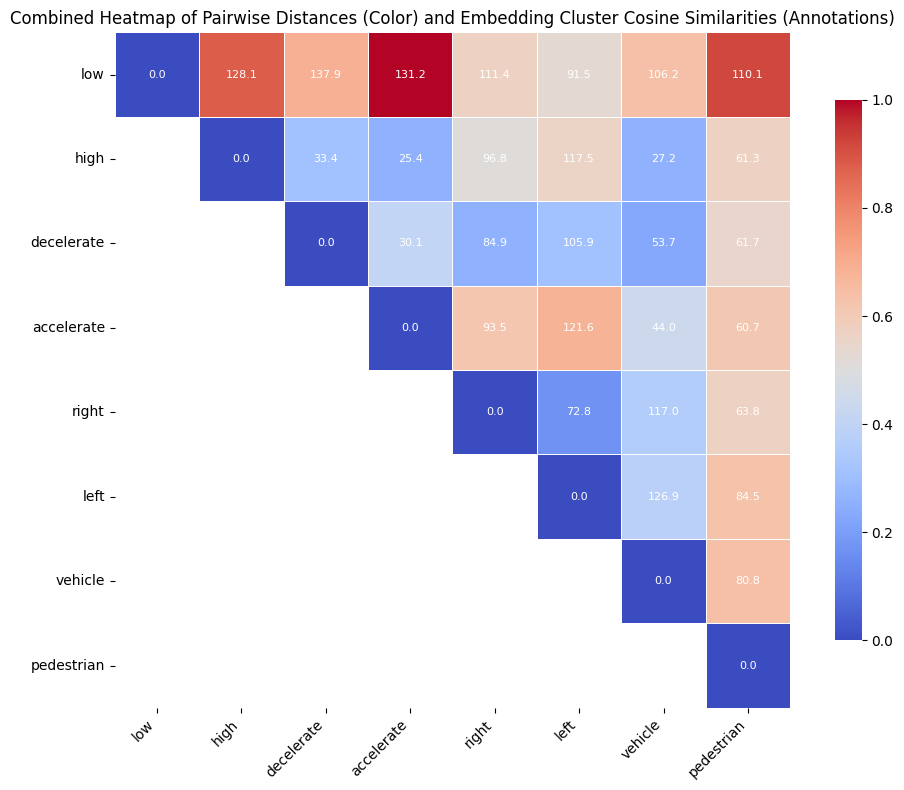

In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# import tikzplotlib

# Pairwise distances matrix (9x9)
distance_matrix = np.asarray(normalized_distances)
distance_matrix = make_symm(distance_matrix)

# Cosine similarity matrix (excluding 'global', 8x8)
cosine_similarity_matrix = np.asarray(cluster_similarity)
cosine_similarity_matrix = make_symm(cosine_similarity_matrix)

# Labels for the clusters
labels = ['low', 'high', 'decelerate', 'accelerate', 'right', 'left', 'vehicle', 'pedestrian']

# Exclude the last row and column ('global') from the distance matrix
adjusted_distance_matrix = distance_matrix[:-1, :-1]

# Convert matrices to DataFrames
dist_df = pd.DataFrame(adjusted_distance_matrix, index=labels, columns=labels)
cos_sim_df = pd.DataFrame(cosine_similarity_matrix, index=labels, columns=labels)

# Create a mask for the lower triangle (including the diagonal)
mask = np.tril(np.ones_like(dist_df, dtype=bool), k=-1)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    dist_df,
    annot=cos_sim_df,
    fmt='.1f',
    cmap='coolwarm',
    mask=mask,
    square=True,
    cbar_kws={"shrink": 0.8},
    annot_kws={"size": 8, "color": "white"},
    linewidths=.5
)

plt.title('Combined Heatmap of Pairwise Distances (Color) and Embedding Cluster Cosine Similarities (Annotations)')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
# tikzplotlib.save("heatmap.tex")
plt.show()

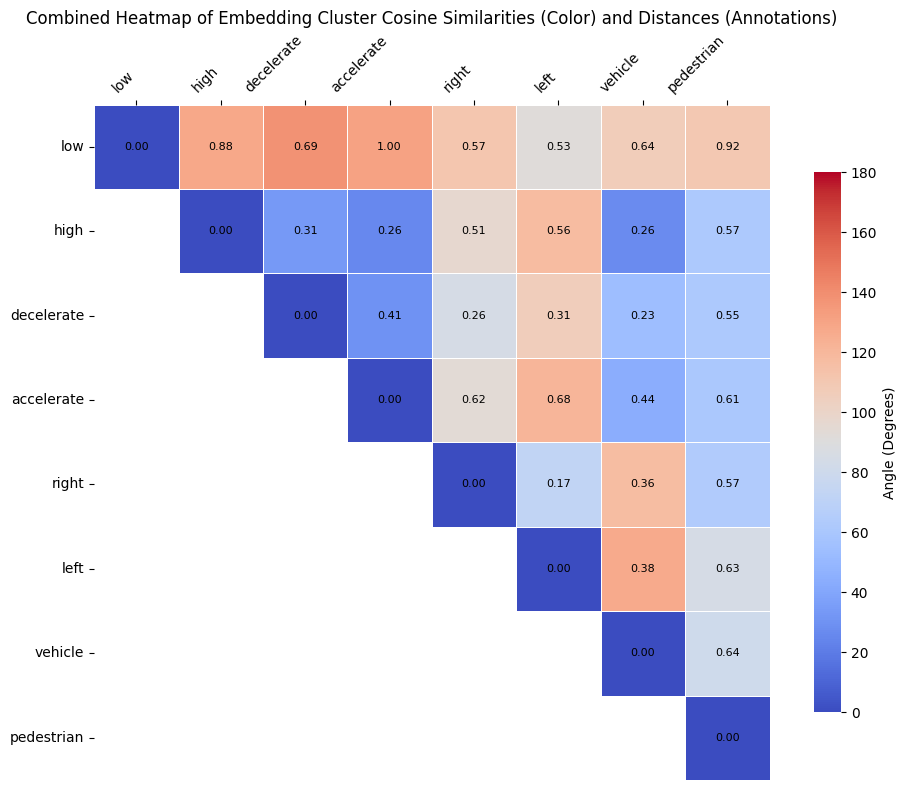

In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# import tikzplotlib  # Uncomment if you want to use tikzplotlib

# Pairwise distances matrix (9x9)
distance_matrix = np.asarray(normalized_distances)
distance_matrix = make_symm(distance_matrix)

# Cosine similarity matrix (excluding 'global', 8x8)
cosine_similarity_matrix = np.asarray(cluster_similarity)
cosine_similarity_matrix = make_symm(cosine_similarity_matrix)

# Labels for the clusters
labels = ['low', 'high', 'decelerate', 'accelerate', 'right', 'left', 'vehicle', 'pedestrian']

# Exclude the last row and column ('global') from the distance matrix
adjusted_distance_matrix = distance_matrix[:-1, :-1]

# Convert matrices to DataFrames
dist_df = pd.DataFrame(adjusted_distance_matrix, index=labels, columns=labels)
cos_sim_df = pd.DataFrame(cosine_similarity_matrix, index=labels, columns=labels)

# Create a mask for the lower triangle (including the diagonal)
mask = np.tril(np.ones_like(cos_sim_df, dtype=bool), k=-1)

# Plot the heatmap
plt.figure(figsize=(10, 8))

# Create a custom colormap that goes from similar (small angles) to dissimilar (large angles)
cmap = sns.color_palette("coolwarm", as_cmap=True)

# Plot the heatmap
ax = sns.heatmap(
    cos_sim_df,
    annot=dist_df,
    fmt='.2f',  # Display distances with two decimal places
    cmap=cmap,
    mask=mask,
    square=True,
    vmin=0,  # Set the minimum of the heatmap to 0 degrees
    vmax=180,  # Set the maximum of the heatmap to 180 degrees
    cbar_kws={"shrink": 0.8, "label": "Angle (Degrees)"},
    annot_kws={"size": 8, "color": "black"},
    linewidths=.5
)

# Move x-axis labels to the top
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

plt.title('Combined Heatmap of Embedding Cluster Cosine Similarities (Color) and Distances (Annotations)')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
# tikzplotlib.save("heatmap.tex")  # Uncomment if you want to use tikzplotlib
plt.show()


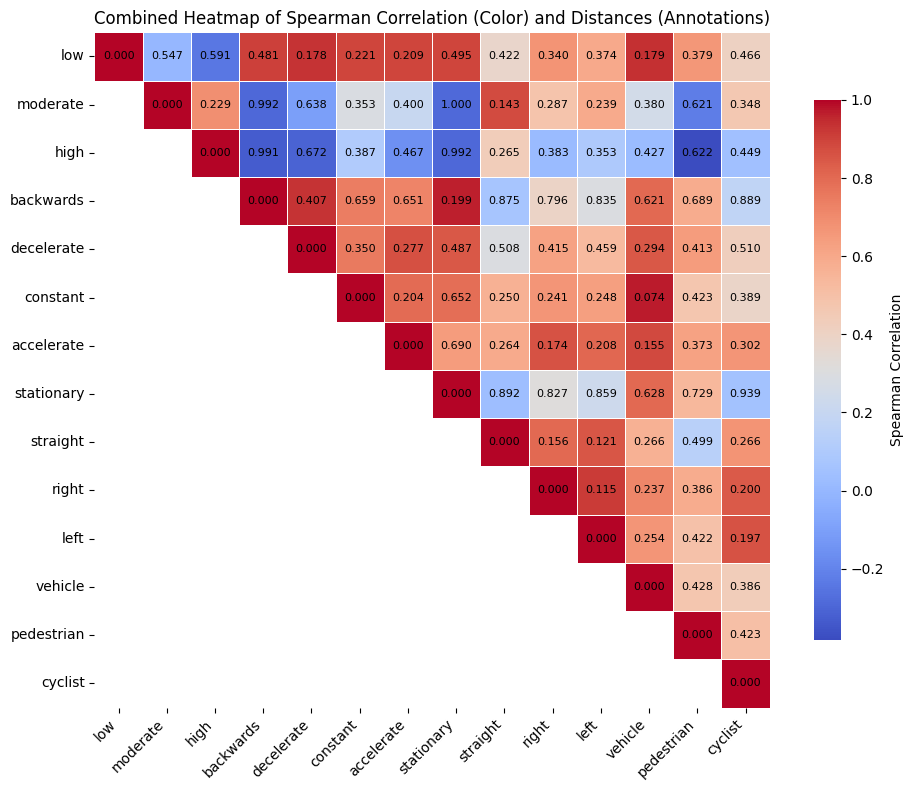

In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import torch
#import tikzplotlib


embedding_matrix = np.array([
    embs["speed"]["low"].mean,
    embs["speed"]["moderate"].mean,
    embs["speed"]["high"].mean,
    embs["speed"]["backwards"].mean,
    embs["acceleration"]["decelerate"].mean,
    embs["acceleration"]["constant"].mean,
    embs["acceleration"]["accelerate"].mean,
    embs["direction"]["stationary"].mean,
    embs["direction"]["straight"].mean,
    embs["direction"]["right"].mean,
    embs["direction"]["left"].mean,
    embs["agent"]["vehicle"].mean,
    embs["agent"]["pedestrian"].mean,
    embs["agent"]["cyclist"].mean,
])


# Labels for the clusters
labels = ['low', 'moderate', 'high', 'backwards', 'decelerate', 'constant', 'accelerate', 'stationary', 'straight', 'right', 'left', 'vehicle', 'pedestrian', 'cyclist' ]

# Step 1: Compute the Spearman correlation matrix
spearman_corr = np.zeros((embedding_matrix.shape[0], embedding_matrix.shape[0]))

for i in range(embedding_matrix.shape[0]):
    for j in range(embedding_matrix.shape[0]):
        corr, _ = spearmanr(embedding_matrix[i], embedding_matrix[j])
        spearman_corr[i, j] = corr


# Step 2: Pairwise distances matrix (normalized values as before)
mean_tensor = torch.empty((len(labels), 128))
mean_tensor[0] = embs["speed"]["low"].mean
mean_tensor[1] = embs["speed"]["moderate"].mean
mean_tensor[2] = embs["speed"]["high"].mean
mean_tensor[3] = embs["speed"]["backwards"].mean
mean_tensor[4] = embs["acceleration"]["decelerate"].mean
mean_tensor[5] = embs["acceleration"]["constant"].mean
mean_tensor[6] = embs["acceleration"]["accelerate"].mean
mean_tensor[7] = embs["direction"]["stationary"].mean
mean_tensor[8] = embs["direction"]["straight"].mean
mean_tensor[9] = embs["direction"]["right"].mean
mean_tensor[10] = embs["direction"]["left"].mean
mean_tensor[11] = embs["agent"]["vehicle"].mean
mean_tensor[12] = embs["agent"]["pedestrian"].mean
mean_tensor[13] = embs["agent"]["cyclist"].mean


distance_matrix = fill_distances_in_matrix(mean_tensor, labels, verbose=False)
distance_matrix = make_symm(distance_matrix)
distance_matrix /= np.max(distance_matrix)


# Step 3: Convert matrices to DataFrames for easier plotting
spearman_df = pd.DataFrame(spearman_corr, index=labels, columns=labels)
dist_df = pd.DataFrame(distance_matrix, index=labels, columns=labels)

# Step 4: Create a mask for the lower triangle (including the diagonal)
mask = np.tril(np.ones_like(spearman_df, dtype=bool), k=-1)

# Step 5: Plot the heatmap
plt.figure(figsize=(10, 8))

# Colormap for Spearman correlation (ranging from -1 to 1)
cmap = sns.diverging_palette(220, 20, as_cmap=True)
cmap = sns.color_palette("coolwarm", as_cmap=True)

sns.heatmap(
    spearman_df,
    annot=dist_df,
    fmt='.3f',
    cmap=cmap,
    mask=mask,
    square=True,
    cbar_kws={"shrink": 0.8, "label": "Spearman Correlation"},
    annot_kws={"size": 8, "color": "black"},
    linewidths=.5
)

plt.title('Combined Heatmap of Spearman Correlation (Color) and Distances (Annotations)')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
# tikzplotlib.save(f"{out_dir}/spearman.tex")
plt.show()
